In [ ]:
# Loading libraries
import pandas as pd

import numpy as np
from numpy import mean
from numpy import std

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from sklearn import metrics 
from sklearn.model_selection import train_test_split 
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import make_classification
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample

import datetime as dt
from datetime import time
from datetime import timedelta

In [ ]:
# Mounting drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# loading datasets
train_df = pd.read_csv("/content/drive/MyDrive/CFG_Project/fraudTrain.csv")
test_df = pd.read_csv("/content/drive/MyDrive/CFG_Project/fraudTest.csv")

In [ ]:
# merging pre-split training and test datasets into one dataframe
df = train_df.append(test_df, ignore_index=True)

In [ ]:
#Removing irrelevant variables
irrelevantVar_list = ['Unnamed: 0',
                      "trans_date_trans_time", 
                      "first", 
                      "last", 
                      "street", 
                      "lat", 
                      "job", 
                      "long",  
                      "cc_num", 
                      "trans_num", 
                      "city", 
                      "zip", 
                      "merchant", 
                      "merch_lat", 
                      "merch_long"]

df.drop(irrelevantVar_list, axis=1, inplace=True)

In [ ]:
# Using the code developed by Juliana to transform the date of birth column into numeric age
yearCharacters = 4
currentYear = int(dt.datetime.now().strftime("%Y"))

df["dob"] = currentYear - df["dob"].str[:yearCharacters].astype(int)

In [ ]:
print(df['is_fraud'].value_counts())

0    1842743
1       9651
Name: is_fraud, dtype: int64


In [ ]:
# Splitting target into majority and minority class
df_majority = df[df.is_fraud==0]
df_minority = df[df.is_fraud==1]

In [ ]:
# Here I am undersampling the majority class without replacement to match the minority class
# df_majority_downsampled = resample(df_majority, 
                                 replace=False,     
                                 n_samples=9651)     

In [ ]:
# Here I am upsampling the minority class with replacement to match the majority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,      
                                 n_samples=1842743)   

In [ ]:
# Creating a dataframe to display the pool of samples selected out of the majority class with the minority class
# df_downsampled = pd.concat([df_majority_downsampled, df_minority])

In [ ]:
# Creating a dataframe to display the inflated minority class with the majority class
df_upsampled = pd.concat([df_minority_upsampled, df_majority])

In [ ]:
# Checking that now both the majority and minority class are comprised of 9651 entries
# print(df_downsampled['is_fraud'].value_counts())

0    9651
1    9651
Name: is_fraud, dtype: int64


In [ ]:
# Checking that now both the majority and minority class are comprised of 1842743 entries
print(df_upsampled['is_fraud'].value_counts())

1    1842743
0    1842743
Name: is_fraud, dtype: int64


In [ ]:
# Defining the feature columns that I will be feeding to the model 

feature_cols = ['dob', 'category', 'amt', 'gender', 'state', 'city_pop', 'unix_time']

In [ ]:
# Defining the input variables X as the feature columns and the target variable y as the label to predict
# using the dataframe created for the downsampling technique

X = df_downsampled[feature_cols] 
y = df_downsampled.is_fraud 

In [ ]:
# Defining the input variables X as the feature columns and the target variable y as the label to predict
# using the dataframe created for the upsampling technique

X = df_upsampled[feature_cols] # Features
y = df_upsampled.is_fraud # Target variable

In [ ]:
# Splitting dataset into training set and test set, the former will be 80% of the dataset and the latter 20%

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [ ]:
# here I am defining the type of transformation I want the column transformer to perform.
# I am specifying the categorical features 'category', 'gender' and 'state' as the targets for OneHotEncoder,
# while the remaining columns should pass through without being affected by the transformation

column_trans = make_column_transformer((OneHotEncoder(handle_unknown='ignore'),
                                        ['category', 'gender', 'state']), 
                                       remainder='passthrough')

In [ ]:
# Here I am defining the model and the pre-processing pipeline that will be applied to it.  
model = LogisticRegression()
pipe = make_pipeline(column_trans, model)

In [ ]:
# Fitting the model and pipeline by using input variables X and target variable y from the training set created previously

t_model = pipe.fit(X_train, y_train)
t_model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['category', 'gender',
                                                   'state'])])),
                ('logisticregression', LogisticRegression())])

In [ ]:
y_pred = t_model.predict(X_test)

In [ ]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[368446,      0],
       [368652,      0]])

Text(0.5, 257.44, 'Predicted label')

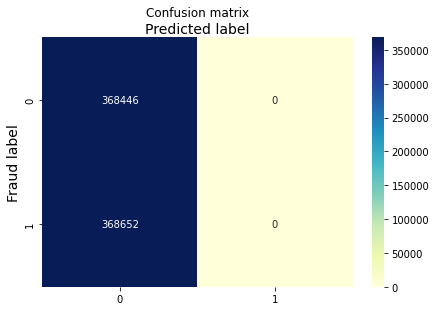

In [ ]:
# specifying name of classes
class_names=[0,1] 
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# creating heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Fraud label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)

In [ ]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.48951048951048953
Precision: 0.48951048951048953
Recall: 1.0


While Juliana has proceeded with testing the decision tree model, I have kept focussing on logistic regression. I tried experimenting with upsampling and downsampling to deal with the unbalanced nature of the dataset and overcome the overfitting issue.

This document contains the necessary code to run both scenarios, just comment out all cells related to 'upsampling' to view the results related to 'downsampling' and vice versa, every cell that is only relevant to execute one of the two techniques is labelled. 

These are the observations I made after experimenting with different parameters:

1. I attempted to use upsampling to artificially inflate the instances of fraud to match those of genuine transactions. This however creates duplicate data of fraudulent transactions, which results in a model prone to overfitting that can still only recognise genuine transactions and never correctly labels instances of fraud.

2. I applied downsampling to only select a smaller pool of genuine transactions to match the number of fraud instances. This initially showed very encouraging metrics, with a decrease in performance for the accuracy score but a significant increase in recall and precision scores. The confusion matrix showed that the logistic regression model was correctly labelling fraudulent transactions in about 70% of cases. However, after restarting the runtime multiple times to test whether different cuts of the downsampled majority class would produce consistent results, it became clear that performance metrics are very inconsistent when using downsampling techniques on this dataset. This method produced models that could only correctly label fraudulent instances, as well as models that could only correctly label genuine transactions and varying combinations of accuracy, recall and precision metrics across the spectrum. It appears that logistic regression cannot successfully overcome overfitting issues through downsampling only in this instance.

3. I experimented with a combination of upsampling and downsampling, however these all produced either overfitted models that could only predict genuine transactions results or underfitted models with accuracy, recall and precision scores of about 50%. 

In conclusion, I cannot find a way forward to harvest resampling techniques to overcome overfitting for this logistic regression model. I will now proceed to test its performance with cross-validation and by applying the encoding pre-processing protocol developed by Juliana. 